## Detect Anomalous Server Activity


In [13]:
import scipy.io as spio
import scipy.stats as stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

#####  The demonstration data consists of two sets of data. Each data point corresponds to a server measurement and consists of two values (features); a latency measurement in mSec and a throughput measurement in Mbs.

##### Data Sets
1. Data set to classify: 307 unlabeled observations with two features: latentcy and throughput
2. Cross validation set: 307 labeled (different) observations identifying the sample as being an inlier of outlier (anomaly)
   

In [14]:
mat_data = spio.loadmat('../data/server_latency_throughput.mat')
X = mat_data.get('X')
latency = X[:,0]
throughput = X[:,1]


#### Histogram the unlabeled data's two features and scatter plot them together.

Text(263.454,0.5,'Throughput')

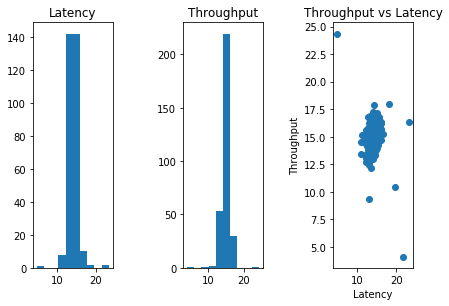

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.tight_layout(w_pad = 4)
axes[0].hist(latency, density=False)
axes[0].set_title("Latency")
axes[1].hist(throughput, density=False)
axes[1].set_title("Throughput")
axes[2].scatter(latency,throughput)
axes[2].set_title("Throughput vs Latency")
axes[2].set_xlabel("Latency")
axes[2].set_ylabel("Throughput")

#### Compute gaussian estimate parameters using unlabeled data.

In [16]:
x_transpose = np.transpose(X)
# mean
mu = np.mean(x_transpose, axis=1)

# covariance
sigma = np.cov(x_transpose, bias=True)

# Outstanding question on why the results are better if only the variances are used from the covariance matrix
p = multivariate_normal.pdf(X, mu, sigma.diagonal())

In [17]:
def visualize_fit(X, mu, sigma):
    n = np.arange(0, 35.5, 0.5)
    x1,x2 = np.meshgrid(n,n)

    Z = multivariate_normal.pdf(np.column_stack((x1.reshape(5041,1), x2.reshape(5041, 1))), mu, sigma.diagonal())
    print(Z.shape)
    Z = Z.reshape(x1.shape)
    plt.plot(X[:,0], X[:,1], 'bx')

    if np.isinf(Z).sum() == 0:
        plt.contour(x1,x2,Z)

#### Link to images of 2 dimensional gaussian images 
https://tinyurl.com/ybesrb2e

(5041,)


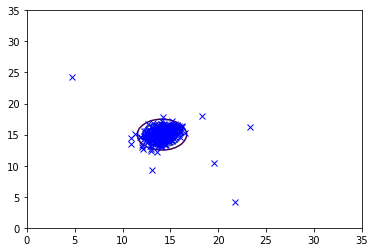

In [18]:

p = multivariate_normal.pdf(X,mu, sigma.diagonal())
visualize_fit(X, mu,  sigma)

#### Compute anomaly threshold usung labeled data

Determine probability threshold for classifying anomalies.

Predicted Positives = true positives + false positives     
Actual Positives = true positives + false negatives

Precision - true positives/number of predicted positives        
Recall - true positives / number of actual positives

F1 Score = 2 * Precision * Recall/(Precision + Recall)

Epsilon is the probability threshold for classifying anomalies. If the probability of a sample is less than epsilon it is classified as an anomaly.

In [19]:
def select_threshold(y_val, p_val):
    
    def compute_precision(true_positives, false_positives):
        if (true_positives + false_positives) != 0:
            precision = true_positives/(true_positives + false_positives)
        else:
            precision = 0
        return precision

    def compute_recall(true_positives, false_negatives):
        if (true_positives + false_negatives) != 0:
            recall = true_positives/(true_positives + false_negatives)
        else:
            recall = 0
        return recall

    def compute_f1(precision, recall):
        if (precision + recall) != 0:
            f1 = 2 * precision * recall/(precision + recall)
        else:
            f1 = 0
        return f1

    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    best_f1_precision = 0
    best_f1_recall = 0
    p_min =  p_val.min()
    p_max = p_val.max()
    step_size = (p_val.max() - p_val.min())/ 1000

    epsilon= p_min
    while epsilon < p_max:
        predictions = p_val < epsilon
        false_positives = np.sum(np.logical_and((predictions == 1), (y_val == 0)))
        true_positives = np.sum(np.logical_and((predictions == 1), (y_val== 1)))
        false_negatives = np.sum(np.logical_and((predictions == 0), (y_val== 1)))
        precision = compute_precision(true_positives, false_positives)
        recall = compute_recall(true_positives, false_negatives)
        f1 = compute_f1(precision, recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_f1_recall = recall
            best_f1_precision = precision
            best_epsilon = epsilon

        epsilon = epsilon + step_size

    return best_epsilon, best_f1, best_f1_recall, best_f1_precision


Determine the threshold with a small set of labeled data, the "cross validation data set"

In [23]:
x_val = mat_data.get('Xval')
y_val = mat_data.get('yval')
y_val= np.reshape(y_val, y_val.shape[0])
print("Labeled cross validation outliers= ", np.count_nonzero(y_val))
p_val = multivariate_normal.pdf(x_val,mu, sigma.diagonal())
(epsilon, f1, recall, precision) = select_threshold(y_val, p_val)
print("cross f1= ", f1)
print("cross precision= ", precision)
print("cross recall= ", recall)

print("computed threshold epsilon= ", epsilon)

Labeled cross validation outliers=  9
cross f1=  0.8750000000000001
cross precision=  1.0
cross recall=  0.7777777777777778
computed threshold epsilon=  8.990852779269493e-05


#### Apply threshold on unlabeled data

Number of data outliers found:  6
(5041,)


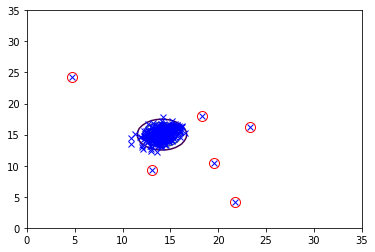

In [24]:
outliers = np.where(p < epsilon)
print("Number of data outliers found:  " + repr(outliers[0].size))

visualize_fit(X, mu,  sigma)
plot1 = X[outliers,0][0]
plot2 = X[outliers,1][0]
plt.plot(plot1, plot2, 'ro', mfc='none',linewidth=2, markersize=10)

##### (Reminder code) Subtraction with broadcasting

In [21]:
x1 = np.array([[2,4,6],[20,40,60]])
print(x1,x1.shape)
x2 = np.array([1,10])
print(x2,x2.shape)
result = x1 - x2[:, np.newaxis]
print()
print(result, result.shape)

mat_result = np.matrix(result)
product = mat_result * mat_result.transpose()
print(product, product.shape)

[[ 2  4  6]
 [20 40 60]] (2, 3)
[ 1 10] (2,)

[[ 1  3  5]
 [10 30 50]] (2, 3)
[[  35  350]
 [ 350 3500]] (2, 2)
